In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
print("import success")

class EnhancementDataset(Dataset):
    def __init__(self, low_res_dir, high_res_dir, transform=None):
        self.low_res_dir = low_res_dir
        self.high_res_dir = high_res_dir
        self.transform = transform
        self.image_files = os.listdir(high_res_dir)

    def __len__(self):
        return len(self.image_files) # Return number of images
    
    def __getitem__(self,index):
        # Get the filename of the image
        img_name = self.image_files[index]
        idx = img_name.index(".png")

        img_name_low = img_name[:idx] + "x2" + img_name[idx:]
        # Construct full paths for low-res and high-res images

        low_res_path = os.path.join(self.low_res_dir, img_name_low)
        high_res_path = os.path.join(self.high_res_dir, img_name)
        
        # Open both images
        low_res_img = Image.open(low_res_path).convert('RGB')
        high_res_img = Image.open(high_res_path).convert('RGB')
        
        # Apply transformations if any
        if self.transform:
            low_res_img = self.transform(low_res_img)
            high_res_img = self.transform(high_res_img)
        
        return low_res_img, high_res_img

import success


In [11]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

In [12]:
dataset = EnhancementDataset('data/low_res', 'data/high_res', transform=transform)


In [14]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [25]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size : tuple, patch_size, embed_dim, in_channels = 3):
        super().__init__()
        self.img_height, self.img_width = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        # Calculate the number of patches 
        self.num_patches_h = self.img_height // self.patch_size
        self.num_patches_w = self.img_width // self.patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        
        # Effective image size 
        self.effective_h = self.num_patches_h * self.patch_size
        self.effective_w = self.num_patches_w * self.patch_size
        
        # Patch embedding layer
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.rand(1, self.num_patches , embed_dim)*0.02)

    def __call__(self, batch_imgs: torch.Tensor):
        assert batch_imgs.dim() == 4, "Expecting batch of images with the shape (BATCH, CHANNEL, HEIGHT, WIDTH)"
        in_batch_size, in_chn, in_h, in_w = batch_imgs.shape
        assert (in_h == self.effective_h and in_w == self.effective_w), f"Input image shape must be ({self.effective_h}, {self.effective_w}) but given ({in_h,in_w})"
        
        # Apply patch embedding
        patch_embedded_image = self.patch_embed(batch_imgs)  # shape: (batch_size, embed_dim, height/patch_size, width/patch_size)
        
        # Reshape to sequence of patches
        patch_sequence_image = patch_embedded_image.flatten(2).transpose(1, 2)  
        # shape: (batch_size, num_patches, embed_dim)
        # flatten(2) combines the two last dimensions of patch_embedded_image, returning shape: (batch_size, embed_dim, num_patches)
        # transpose switches the last and the middle axes, resulting in shape: (batch_size, num_patches, embed_dim)
        
        # Add positional embedding
        patch_sequence_image += self.pos_embed
        
        return patch_sequence_image

In [26]:
def create_test_image(size=(224, 224)):
    # Create a simple test image (checkerboard pattern)
    image = torch.zeros((1, 3, size[0], size[1]))
    for i in range(0, size[0], 16):
        for j in range(0, size[1], 16):
            if (i // 16 + j // 16) % 2 == 0:
                image[0, :, i:i+16, j:j+16] = 1
    return image

test_image = create_test_image()

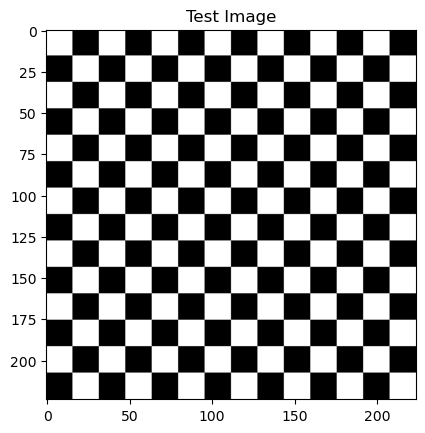

In [27]:
plt.imshow(test_image.squeeze().permute(1, 2, 0))
plt.title("Test Image")
plt.show()

In [28]:
patch_embed = PatchEmbedding(image_size=(224, 224), patch_size=16, embed_dim=128)

In [29]:
with torch.no_grad():
    embedded_patches = patch_embed(test_image)

print("Embedded patches shape:", embedded_patches.shape)

Embedded patches shape: torch.Size([1, 196, 128])


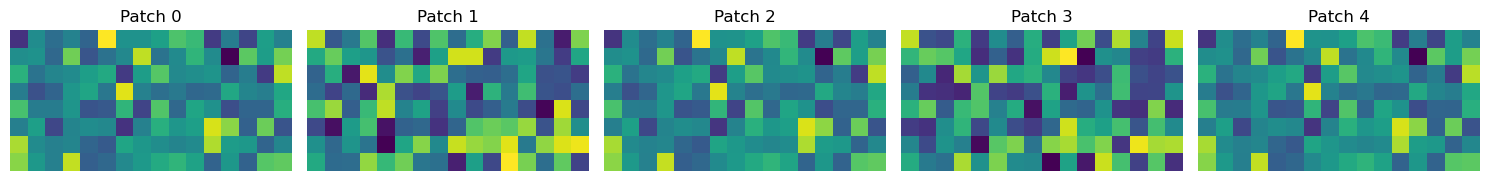

In [30]:
def visualize_embeddings(embedded_patches, num_patches=5):
    fig, axes = plt.subplots(1, num_patches, figsize=(15, 3))
    for i in range(num_patches):
        axes[i].imshow(embedded_patches[0, i].reshape(8, 16).detach().numpy(), cmap='viridis')
        axes[i].set_title(f"Patch {i}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_embeddings(embedded_patches)

Positional embedding shape: torch.Size([1, 196, 128])


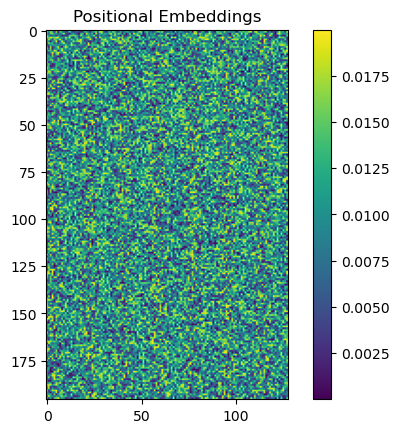

In [31]:
print("Positional embedding shape:", patch_embed.pos_embed.shape)
plt.imshow(patch_embed.pos_embed.squeeze().detach().numpy(), cmap='viridis')
plt.title("Positional Embeddings")
plt.colorbar()
plt.show()